## Реализация численного решения уравнения Дарси

$$
S_s \frac{\partial h(x,y,t)}{\partial t} - \nabla \cdot (K(x, y) \nabla h(x,y,t)) = q(x,y)
$$

$$
h(x, y) = h_D(x, y) ~на~ \Gamma_D
$$

$$
K(x,y) \nabla h(x,y,t) \cdot n(x,y) = g(x,y) ~на~ \Gamma_N
$$

где $S_s$ - specific storage - задано; $h(x,y,t)$ - напор (hydraulic head) - искомая функция; $K(x,y)$ - проводимость (hydraulic conductivity) - задано;  $g(x,y)$ - поток (flux) на части границы с условием Неймана, задано; $n(x,y)$ - единичный вектор нормали к области; $q(x,y)$ - заданная функция.

В данном случае - условия Дирихле заданы в середине области $p = const$, условия Неймана заданы на границе области (стороны прямоугольника) $g(x) = 0$, $q(x,y) = 0$ - везде, кроме точки посредине области (скважина).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import tqdm

### Load perm. and press. data and plot samples

In [2]:
perm = np.load('perm1_470.npy')
press = np.load('pressure1_470.npy')

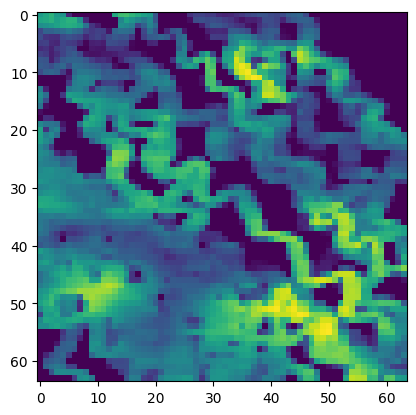

In [3]:
i = 100  # number of sample
plt.imshow(perm[i], cmap='viridis', interpolation='nearest')
plt.show()

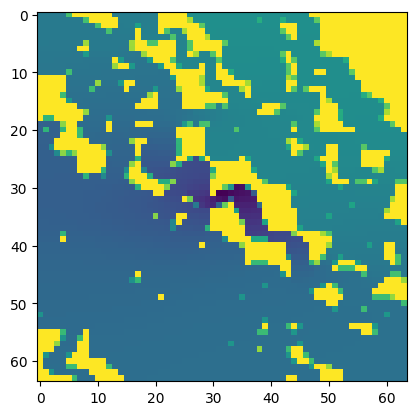

In [4]:
plt.imshow(press[i][-1], cmap='viridis', interpolation='nearest')
plt.show()

### Initial parameters 

In [5]:
plate_length = perm.shape[1]
print(f'{plate_length=}')

max_iter_time = 10

delta_x = 1
delta_y = delta_x

delta_t = 0.0001

tau = delta_t
S_s = 2e-4

plate_length=64


### Boundary and initial cond.

In [6]:
u = np.empty((max_iter_time, plate_length, plate_length))

u_initial = 100  # начальное знач. напора везде одинаково

u_top = 100.0
u_left = 100.0
u_bottom = 100.0
u_right = 100.0

u.fill(u_initial)

u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

### K - perm./cond. and q function

$$
K = \frac{k \rho g}{\mu}
$$

$$k = \frac{K \mu}{\rho g}$$

$K$ - hydraulic conductivity, $k$ - intrinsic permeability, $\mu$ is the fluid viscosity

(https://ebrary.net/132417/environment/hydraulic_conductivity_intrinsic_permeability)

In [8]:
# mu, sigma = 3., 1. # mean and standard deviation
# K = np.random.lognormal(mu, sigma, (plate_length, plate_length))

# Что такое perm из файла? 
mu = 0.001
rho = 800
g = 9.82
# K = (perm[1] * 9.82 * 800) / mu
# K = (perm[1] * mu) / (rho * g)
K = perm[i]

In [9]:
q = np.zeros((plate_length, plate_length))
q[q.shape[0] // 2, q.shape[1] // 2] = 1000  #!

### Numerical scheme implementation

In [10]:
def hmean(k1, k2):
    """harmonic mean for k1 and k2."""
    # print(f"{k1=}, {k2=}")
    return 2 * (k1 * k2) / (k1 + k2)

hmean(2, 5)

2.857142857142857

In [11]:
# Функция для условия Неймана
def g_func(x, y):
    return np.zeros_like(x)  #! нулевая

In [12]:
def neumann_boundary_conditions(u, g_func, k, Dx, Dy):
    # Применение условий Неймана на границе
    _, Nx, Ny = u.shape
    u_new = u.copy()

    # Верхняя граница
    u_new[k, -1, :] = u[k, -2, :] + g_func(0, np.arange(Ny) * Dy)

    # Нижняя граница
    u_new[k, 0, :] = u[k, 1, :] - g_func(0, np.arange(Ny) * Dy)

    # Левая граница
    u_new[k, :, 0] = u[k, :, 1] - g_func(np.arange(Nx) * Dx, 0)

    # Правая граница
    u_new[k, :, -1] = u[k, :, -2] + g_func(np.arange(Nx) * Dx, 0)

    return u_new

In [13]:
def calculate(u):
    tau = 0.9 * min(delta_x, delta_y)**2 / (2 * np.max(K))

    for k in tqdm.tqdm(range(0, max_iter_time-1, 1)):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                R1 = (hmean(K[i, j], K[i+1, j]) * (u[k, i+1, j] - u[k, i, j]) + hmean(K[i, j], K[i-1, j]) * (u[k, i-1, j] - u[k, i, j])) / (delta_x**2)
                R2 = (hmean(K[i, j], K[i, j+1]) * (u[k, i, j+1] - u[k, i, j]) + hmean(K[i, j], K[i, j-1]) * (u[k, i, j-1] - u[k, i, j])) / (delta_y**2)
                u[k + 1, i, j] = tau * ((R1 + R2) + q[i, j]) / S_s  + u[k, i, j]
        u = neumann_boundary_conditions(u, g_func, k+1, delta_x, delta_y)
    return u

In [14]:
def plotheatmap(u_k, k):
    plt.clf()

    plt.title(f"Hydr. head at t = {k*delta_t:.3f}")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

In [15]:
u = calculate(u)

  0%|                                                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\79241\AppData\Local\Temp\ipykernel_28480\3153596425.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * (k1 * k2) / (k1 + k2)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.69it/s]


In [16]:
u.shape

(10, 64, 64)

In [17]:
def animate(k):
    plotheatmap(u[k], k)

MovieWriter ffmpeg unavailable; using Pillow instead.


Done!


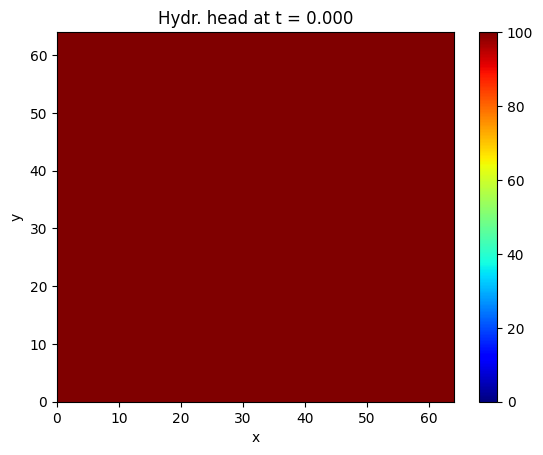

In [18]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("darcy_equation_numerical_solution.gif")

print("Done!")

## ver. 2

In [19]:
plate_length = perm.shape[1]

 40%|█████████████████████████████████████████████▊                                                                   | 81/200 [00:38<00:56,  2.12it/s]C:\Users\79241\AppData\Local\Temp\ipykernel_28480\1757381249.py:59: RuntimeWarning: overflow encountered in multiply
  h[:, :, n + 1] = h[:, :, n] + (Dt * (hydraulic_conductivity(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)) *
 41%|██████████████████████████████████████████████▎                                                                  | 82/200 [00:38<00:56,  2.10it/s]C:\Users\79241\AppData\Local\Temp\ipykernel_28480\1757381249.py:59: RuntimeWarning: invalid value encountered in add
  h[:, :, n + 1] = h[:, :, n] + (Dt * (hydraulic_conductivity(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)) *
C:\Users\79241\AppData\Local\Temp\ipykernel_28480\1757381249.py:59: RuntimeWarning: invalid value encountered in multiply
  h[:, :, n + 1] = h[:, :, n] + (Dt * (hydraulic_conductivity(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)) *
C:\Use

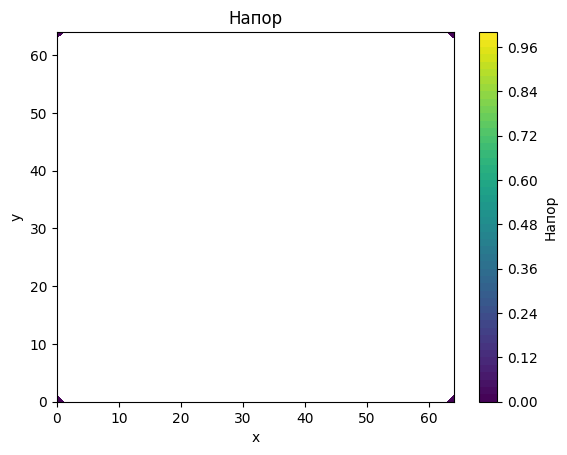

In [49]:
import numpy as np
import matplotlib.pyplot as plt

#  параметры
Lx = plate_length # 1.0  # Длина области вдоль оси x
Ly = plate_length # 1.0  # Длина области вдоль оси y
Nx = plate_length   # Количество узлов по оси x
Ny = plate_length   # Количество узлов по оси y
T = 1.0   # Общее время
Nt = 200  # Количество временных шагов
Dx = 1 # Lx / (Nx - 1)  # Шаг по оси x
Dy = 1 # Ly / (Ny - 1)  # Шаг по оси y
Dt = T / Nt         # Шаг по времени

# проводимость K(x, y)
def hydraulic_conductivity(x, y):
    # mu, sigma = 3., 1. # mean and standard deviation
    # return np.random.lognormal(mu, sigma, (plate_length, plate_length))
    return perm[i]


# q(x, y)
def source_term(x, y, t):
    q = np.zeros((Nx, Ny))
    q[q.shape[0] // 2, q.shape[1] // 2] = 1 #!
    return q


# условия Дирихле - в центре скважины
def dirichlet_cond(h, n):
    h[h.shape[0] // 2, h.shape[1] // 2, n] = 1 #!
    return h


# условия Неймана
def neumann_boundary_condition(x, y, t):
    return np.zeros((Nx, Ny))  # равны нулю!


h = np.zeros((Nx, Ny, Nt+1))


# Начальное условие h
def initial_condition(x, y):
    return np.zeros((Nx, Ny))


h[:, :, 0] = initial_condition(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))

Dt = 0.9 * min(Dx, Dy)**2 / (2 * np.max(hydraulic_conductivity(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))))

for n in tqdm.tqdm(range(Nt)):
    laplacian_h = np.zeros((Nx, Ny))
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            laplacian_h[i, j] = (h[i + 1, j, n] - 2 * h[i, j, n] + h[i - 1, j, n]) / Dx**2 + \
                                (h[i, j + 1, n] - 2 * h[i, j, n] + h[i, j - 1, n]) / Dy**2

            h[:, :, n + 1] = h[:, :, n] + (Dt * (hydraulic_conductivity(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)) *
                                       laplacian_h - source_term(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), n * Dt))) /S_s

            h[:, :, n + 1] += neumann_boundary_condition(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), (n + 1) * Dt) * Dt
            h = dirichlet_cond(h, n+1)

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, h[:, :, -1], levels=50, cmap='viridis')
plt.colorbar(label='Напор')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Напор')
plt.show()

In [46]:
def plotheatmap(u_k, k):
    plt.clf()

    plt.title(f"Hydr. head at t = {k*Dt:.3f}")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=-10, vmax=10000000)
    plt.colorbar()

    return plt

In [47]:
def animate(k):
    plotheatmap(h[:,:,k], k)

MovieWriter ffmpeg unavailable; using Pillow instead.


Done!


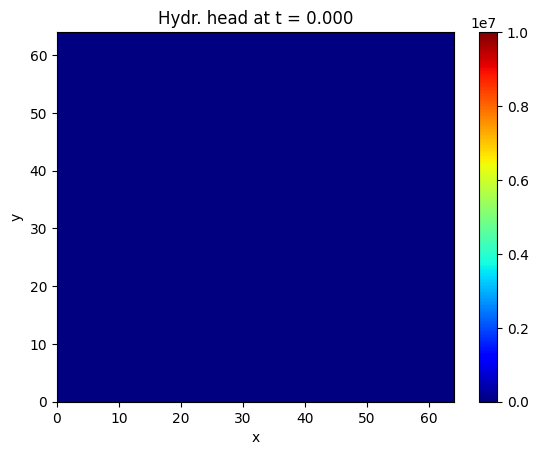

In [48]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=Nt, repeat=False)
anim.save("darcy_equation_numerical_solution_v2.gif")

print("Done!")